# Produce lifetime XY map

### Run 5880: 19-06-2018 night
- low lifetime run, with sources and closed castle, lifetime recovering
- pressure: 10 bar
- Gate voltage: 8 kV
- Low lifetime

### Notebook configuration

In [132]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import matplotlib.pyplot as plt
# Plotting style
default_cmap = "jet"

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [96]:
import os
import time
import datetime
import collections
import glob

import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string


from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [4]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from   invisible_cities.evm  .ic_containers  import Measurement

In [5]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [6]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [7]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [8]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Tue Jun 19 11:28:53 2018


In [189]:
def figsize(type="small"):
    if type == "S":
        plt.rcParams["figure.figsize"]  = 8, 6
    elif type == "s":
         plt.rcParams["figure.figsize"] = 6, 4
    elif type == "l":
        plt.rcParams["figure.figsize"] = 10, 8 
    else:
        plt.rcParams["figure.figsize"] = 12, 10    
   

### Files

In [11]:
path = f"/Users/jjgomezcadenas/Projects/ICDEV/kdst"
run_number          = 5880
input_dst_filenames = f"{path}/{run_number}/kdst*.h5"
input_dst_filename  = f"{path}/{run_number}/kdst_{run_number}_s1s2.h5"

print(f"run number = {run_number}")
print(f"input dst = {input_dst_filename}")


run number = 5880
input dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5880/kdst_5880_s1s2.h5


In [12]:
output_dst_filename = f"{path}/{run_number}/kdst_{run_number}_map_lt.h5"
print(f"output dst = {output_dst_filename}")

output dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5880/kdst_5880_map_lt.h5


### Read data

In [134]:
#dst = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
dst_full           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 2392835 
Total number of events: 2392835


In [135]:
dst_full.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [155]:
Zrange  =  100,  550
XYrange = -180,  180
Rrange  =  0, max(XYrange)
Erange  =  2e3, 20e3
Qrange  =  100, 1500
Znbins  =   10
XYnbins =   50
Enbins  =   50
Qnbins  =   50

nStimeprofile = 7200 # (in seconds, thus one point per hour)

Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

In [137]:
dst = dst_full[dst_full.R<max(Rrange)] 

In [138]:
print("Ratio full/dst:", len(dst)/len(dst_full))

Ratio full/dst: 0.8034895845304837


In [156]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values
Q = dst.S2q.values
T = dst_time.time.values

dst_time = dst.sort_values('event')

tstart = dst_time.time.values[ 0]
tfinal = dst_time.time.values[-1]
Trange = tstart, tfinal

ntimebins = int( np.floor( ( tfinal - tstart) / nStimeprofile) )
Tnbins = np.max([ntimebins, 1])

Tbins = np.linspace( tstart, tfinal, ntimebins+1)


krEvent = KrEvent(X = dst.X.values,
                  Y = dst.Y.values,
                  Z = dst.Z.values,
                  T = dst_time.time.values,
                  E = dst.S2e.values,
                  Q = dst.S2q.values)

In [157]:
krNBins  = KrNBins(E = Enbins, Q = Qnbins, Z = Znbins, XY = XYnbins, T = Tnbins)
krRanges = KrRanges(E = Erange, Q = Qrange, Z = Zrange, XY = XYrange, T = Trange)
krBins   = KrBins(E = Ebins, Q = Qbins, Z = Zbins, XY = XYbins, cXY = XYcenters, T = Tbins) 

In [158]:
print(f'tstart ={datetime.datetime.fromtimestamp(tstart)}')
print(f'tfinal ={datetime.datetime.fromtimestamp(tfinal)}')

tstart =2018-06-18 15:17:33.410000
tfinal =2018-06-20 16:54:32.254000


In [159]:
times = [np.mean([Tbins[t],Tbins[t+1]]) for t in range(Tnbins)]
TL = [(Tbins[t],Tbins[t+1]) for t in range(Tnbins)]
timeStamps = list(map(datetime.datetime.fromtimestamp, times))

In [160]:
def s2_time_profile(T, E, Tnbins, Trange, timeStamps):
    x, y, yu = fitf.profileX(T, E, Tnbins, Trange)
    plt.figure()
    ax=plt.gca()
    xfmt = md.DateFormatter('%d-%m %H:%M')
    ax.xaxis.set_major_formatter(xfmt)  
    plt.errorbar(timeStamps, y, yu, fmt="kp", ms=7, lw=3)
    plt.xlabel('date')
    plt.ylabel('S2 (pes)')
    plt.xticks( rotation=25 )

In [161]:
len(T)

1922618

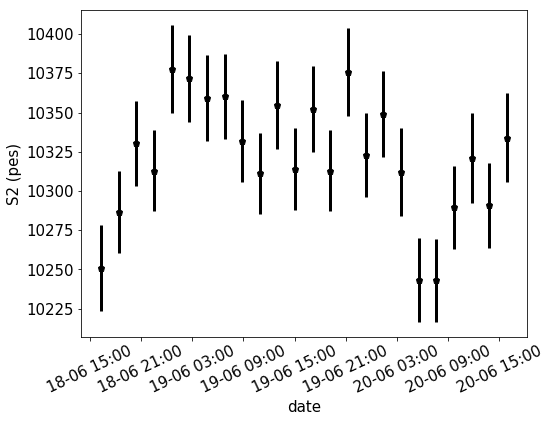

In [162]:
s2_time_profile(T, E, Tnbins, Trange, timeStamps)

### Event distribution

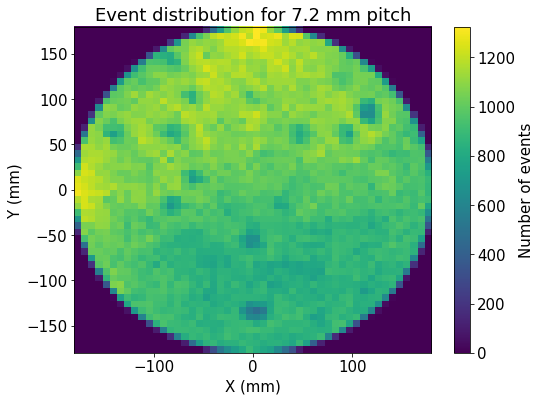

In [163]:
figsize("S")
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

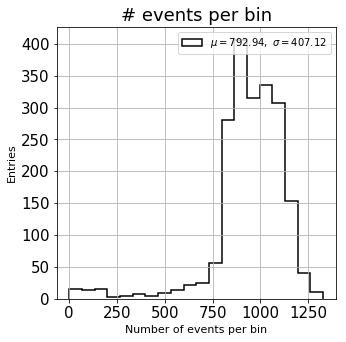

In [164]:
nevt_max = int(np.max(nevt))
mu, sigma = krh.h1d(nevt.flatten(), bins=20, range=(1, nevt_max + 2),
        xlabel='Number of events per bin', ylabel='Entries',
        title="# events per bin", legend = 'upper right',figsize=(5,5))

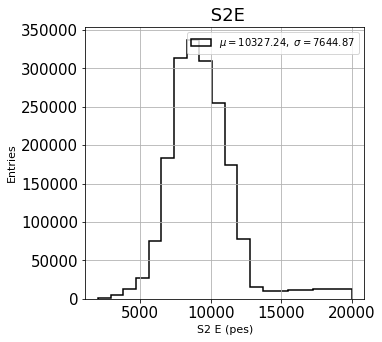

In [165]:
mu, sigma = krh.h1d(E, bins=20, range=(Erange[0], Erange[1]),
        xlabel='S2 E (pes)', ylabel='Entries',
        title=" S2E", legend = 'upper right',figsize=(5,5))

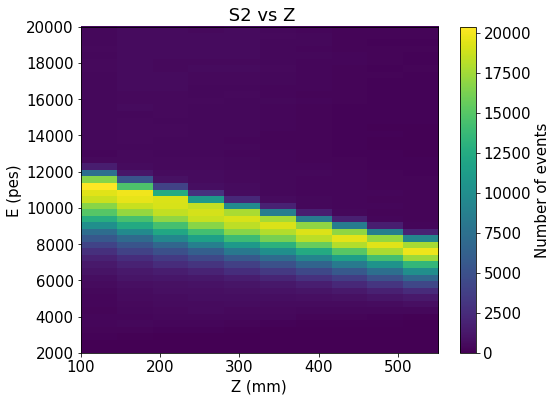

In [166]:
figsize("S")
nevt, *_ = plt.hist2d(Z, E, (Zbins, Ebins))
plt.colorbar().set_label("Number of events")
labels("Z (mm)", "E (pes)", f" S2 vs Z")

### Fit near center of chamber

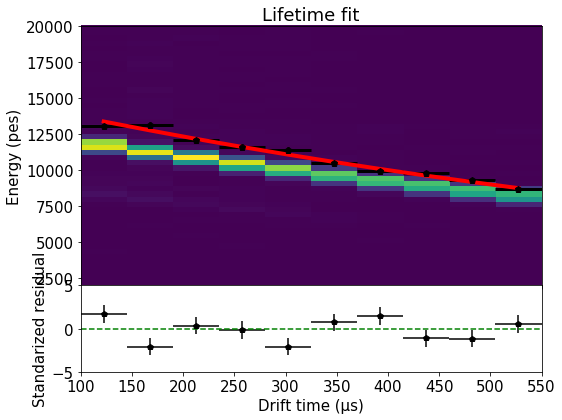

In [167]:
xlim =  -25, 25
ylim =  -25, 25
xyr = XYRanges(X=xlim, Y=ylim )

kf = krf.lifetime_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr)

In [168]:
krf.print_fit(kf)

 E (z=0) = 15214.402297424294 +-164.22583732624068 
 LT      = -954.6147681155362 +-26.3003726211292 
 chi2    = 1.4222235489723887 


### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
 E (z=0) = 14087.217389991714 +-132.26701115787492 
 LT      = -942.1135451247086 +-22.34551515023721 
 chi2    = 0.8361373961872066 
xlim = (-125, -75), ylim =(75, 125)
 E (z=0) = 12870.306059541834 +-118.94108673394007 
 LT      = -978.6684006521963 +-27.650355924703174 
 chi2    = 2.102292480965618 
xlim = (75, 125), ylim =(75, 125)
 E (z=0) = 11828.402089210393 +-102.60629326950168 
 LT      = -1125.686035248761 +-31.786951604222 
 chi2    = 2.6424380387501927 
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 12235.49301846995 +-96.34008975516888 
 LT      = -1171.9560544338503 +-28.319590454136026 
 chi2    = 1.606115941284598 


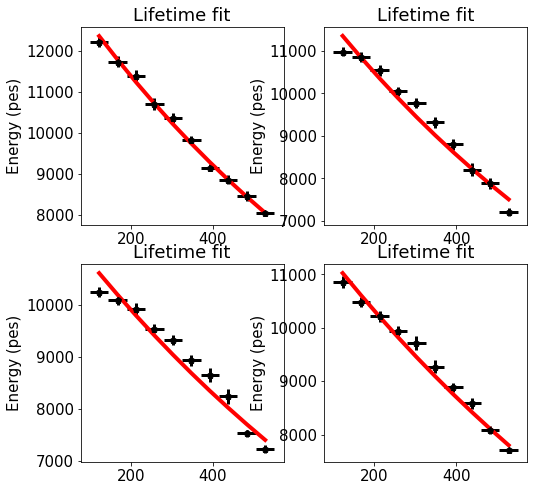

In [169]:
krf.lifetimes_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))

### Time profile

In [178]:
from typing      import List
def lifetimes_in_TRange(kre : KrEvent,
                        krnb: KrNBins,
                        krb : KrBins,
                        krr : KrRanges,
                        TL)->List[KrFit]:
    """ Plots lifetime fitted to a range of T values"""


    # Specify the range and number of bins in Z
    Znbins = krnb.Z
    Zrange = krr.Z

    kfs=[]
    for  tlim in TL:

        # select data 
        kre_t = krf.select_in_TRange(kre, *tlim)
        z, e = kre_t.Z, kre_t.E

        x, y, yu = fitf.profileX(z, e, Znbins, Zrange)
        # Fit profile to an exponential
        seed = expo_seed(x, y)
        f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)


        kf = KrFit(par  = np.array(f.values),
                   err  = np.array(f.errors),
                   chi2 = krf.chi2(f, x, y, yu))


        #krf.print_fit(kf)
        kfs.append(kf)
    
    return kfs
        



In [179]:
fits = lifetimes_in_TRange(krEvent, krNBins, krBins, krRanges,  TL=TL)

In [171]:
def s2_time_profile(T, E, Tnbins, Trange, timeStamps):
    x, y, yu = fitf.profileX(T, E, Tnbins, Trange)
    plt.figure()
    ax=plt.gca()
    xfmt = md.DateFormatter('%d-%m %H:%M')
    ax.xaxis.set_major_formatter(xfmt)  
    plt.errorbar(timeStamps, y, yu, fmt="kp", ms=7, lw=3)
    plt.xlabel('date')
    plt.ylabel('Lifetime (mus)')
    plt.xticks( rotation=25 )

In [172]:
def plot_lifetime_T(kfs, timeStamps):        
    ez0s = [kf.par[0] for kf in kfs]
    lts = [np.abs(kf.par[1]) for kf in kfs]
    u_ez0s = [kf.err[0] for kf in kfs]
    u_lts = [kf.err[1] for kf in kfs]
    plt.figure()
    ax=plt.gca()
    xfmt = md.DateFormatter('%d-%m %H:%M')
    ax.xaxis.set_major_formatter(xfmt)  
    plt.errorbar(timeStamps, lts, u_lts, fmt="kp", ms=7, lw=3)
    plt.xlabel('date')
    plt.ylabel('Lifetime (mus)')
    plt.xticks( rotation=25 )

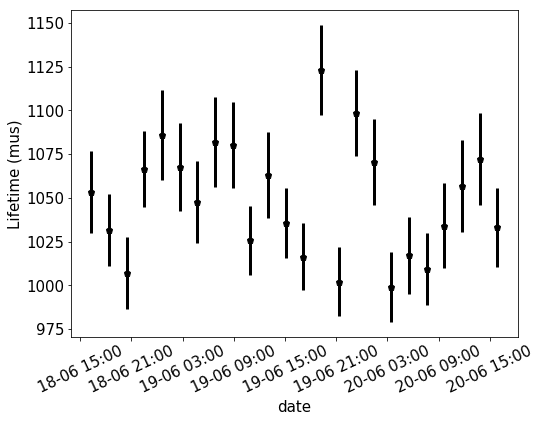

In [175]:
plot_lifetime_T(fits, timeStamps)

### Compute lifetime maps

In [180]:
krfs = krf.fit_lifetime_slices(krEvent, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [181]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [182]:
valid.shape

(50, 50)

In [183]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.786

In [184]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =1127.0536216575977 +- 341.888707226254
Lifetime uncertainty     : mu +- std =11.788165629311774 +- 5.679844478708634
Energy scale value       : mu +- std =12582.741389665583 +- 1494.266933802003
Energy scale uncertainty : mu +- std =3.8013119024752022 +- 1.4114249889448993


In [185]:
n_sigma  = 2.5
u_sigma  = 2.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 8847.074055160576; E_max = 16318.408724170591
 Lifetime (ELT): ELT_min = 272.3318535919627; ELT_max = 1981.7753897232326
 Energy scale error (Eu): Eu_min = 0.27274943011295383; Eu_max = 7.32987437483745
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 25.98777682608336


### Map display

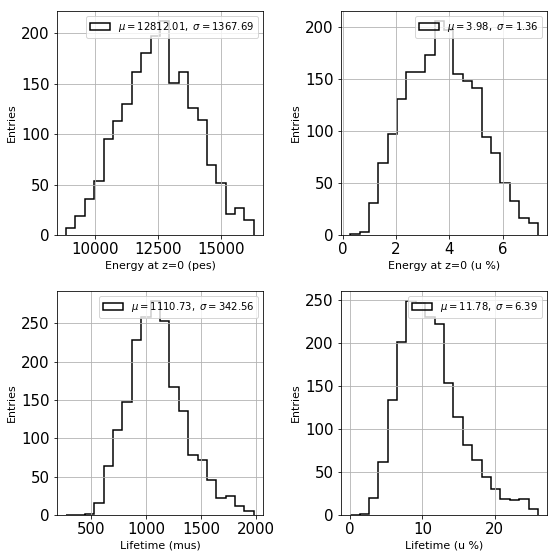

In [186]:
krh.h1d_4((Escale.value[valid],Escale.uncertainty[valid],
          ELT.value[valid],ELT.uncertainty[valid]),
          (20,20,20,20),
          (kltl.Es.interval,kltl.Eu.interval,kltl.LT.interval,kltl.LTu.interval),
          ('Energy at z=0 (pes)','Energy at z=0 (u %)','Lifetime (mus)', 'Lifetime (u %)'),
          ('Entries','Entries','Entries','Entries'),
          titles  =None,
          legends = ('best','best','best','best'),
          figsize =(8,8))


In [187]:
invalid = ~valid
mask = valid

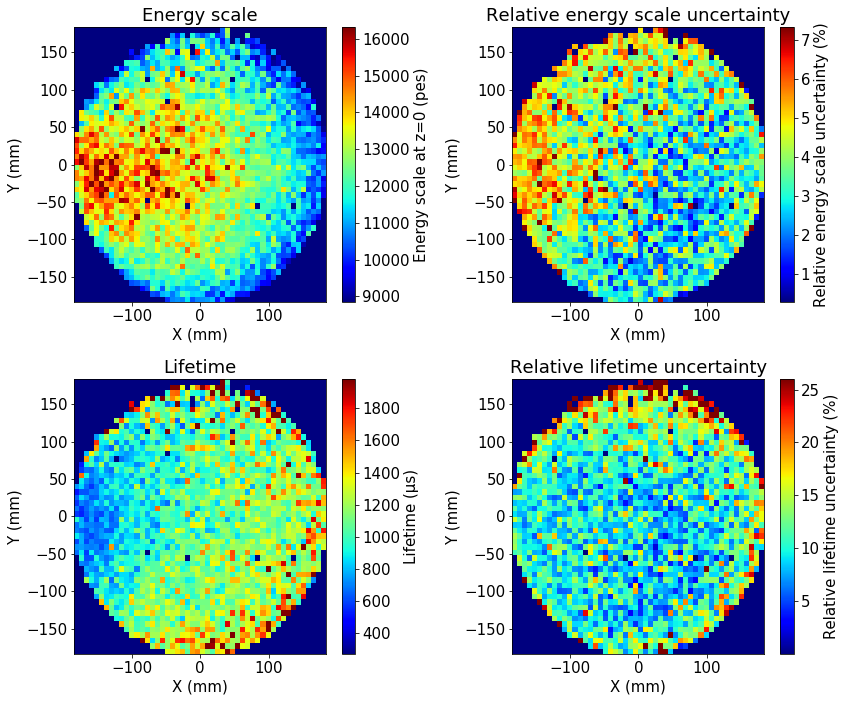

In [190]:
figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=valid)
                         

(1.416305242834063, 0.697212005341871)

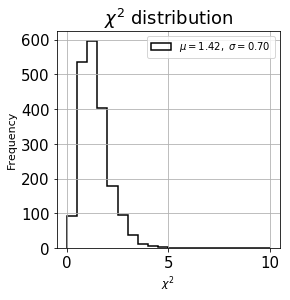

In [191]:
figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

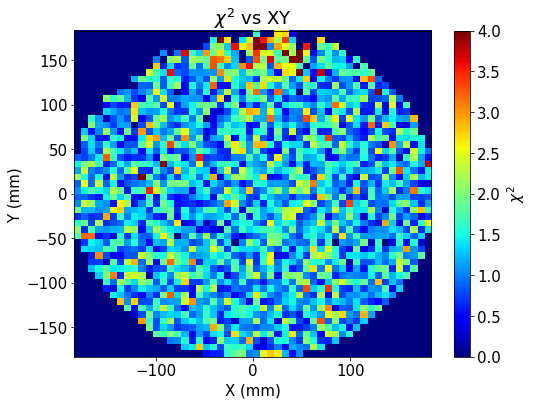

In [192]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

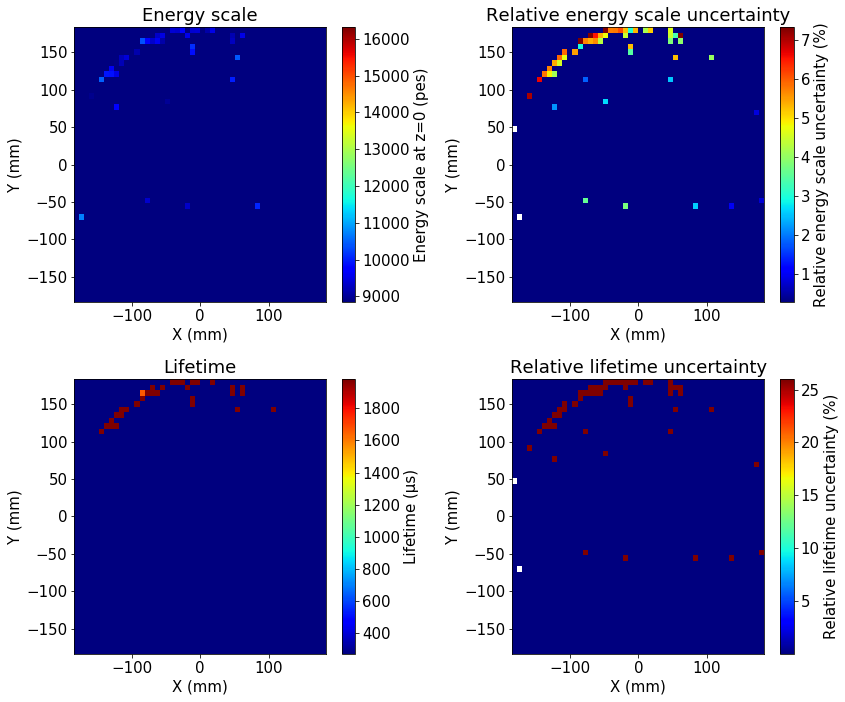

In [193]:
figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=invalid)

### Fix map

- Fill bins where fit has failed with average value of lifetime

In [194]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value      ,     Es.mu), 
                     np.where(valid, Escale_abs.uncertainty,       Es.mu_u * Es.mu / 100 ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , El.mu), 
                  np.where(valid,  ELT_abs.uncertainty,    El.mu_u * El.mu / 100))

In [195]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

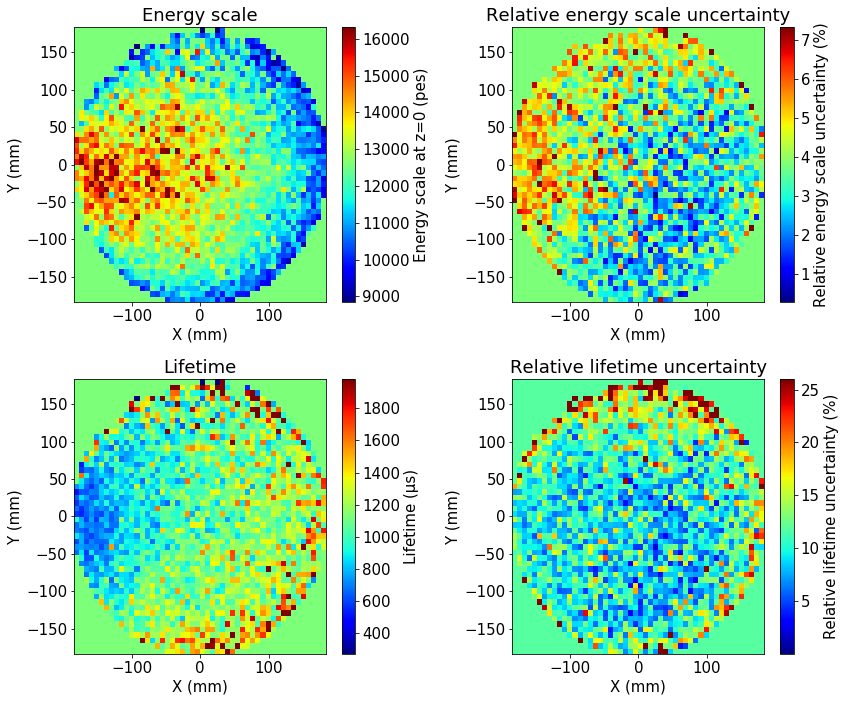

In [196]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, XYcenters, cmap="jet", mask=None)

### Produce HDF5 output

In [198]:
with tb.open_file(output_dst_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch



IndexError: index 10 is out of bounds for axis 0 with size 10

### END